<h1 style="text-align: center;">TinyML based Vocal Emotion Classifier</h1>

### Introduction  

- This notebook focuses on building a **Vocal Emotion Classifier ** model using **LSTM architecture** and **MFCCs**, known for their effectiveness in sequence learning and SER tasks.  
- **TinyML** enables deploying the model on resource-constrained devices (e.g., microcontrollers, mobile devices, IoT, wearables).  
- The **circumplex model of emotions** is used, classifying emotions based on **valence** (pleasantness) and **arousal** (intensity).  
  - Categories "Fear" and "Disgusted" are dropped.  
  - "Angry" and "Sad" are merged into **"Unpleasant"**, focusing on four emotions: **Happy**, **Surprised**, **Neutral**, and **Unpleasant**.  
- Data comes from **RAVDESS**, **TESS**, and **SAVEE** datasets, with preprocessing and visualization of waveforms and spectrograms.  
- **Data augmentation** techniques (noise addition, stretching, pitching) are used to improve performance.  
- The trained model is converted to **TensorFlow Lite (TFLite)**, quantized to reduce size, and tested for inference time.  
- Final deployment is possible on hardware like the **Arduino Nano 33 BLE Sense**.  

## Importing Libraries
Include the necessary libraries for data manipulation, visualization, feature extraction, model building, and model conversion:

In [1]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Dataset
We will use three different datasets for speech emotion recognition: RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song), TESS (Toronto Emotional Speech Set), and SAVEE (Surrey Audio-Visual Expressed Emotion). These datasets offer several benefits that contribute to the development of more robust and accurate SER models:

1. Variety of emotional expressions:<br> These datasets encompass a wide range of emotions, such as happy, sad, angry, fearful, surprised, disgusted, and neutral. This variety helps train models to recognize and distinguish subtle differences between various emotional expressions, enhancing their performance.

2. Multiple speakers:<br> Including multiple speakers with different accents, genders, and speaking styles provide a more diverse and representative speech data sample. This diversity helps models generalize to real-world scenarios, making them more effective in handling speech data from various sources.

3. High-quality recordings:<br> The audio files in these datasets are recorded with high-quality equipment, resulting in clear and consistent audio samples, allowing models to focus on the emotional content of the speech without being hindered by noise or other artifacts.

In [2]:
# Paths for data.
Ravdess = "/Users/vaibhavtiwari/Downloads/archive/audio_speech_actors_01-24/"
Tess = "/Users/vaibhavtiwari/Downloads/archive (1)/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data"
Savee = "/Users/vaibhavtiwari/Downloads/ALL"

In [3]:
import os
import pandas as pd

# Define the path to the RAVDESS dataset
Ravdess = '/Users/vaibhavtiwari/Downloads/archive/audio_speech_actors_01-24/'
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    dir_path = os.path.join(Ravdess, dir)
    if os.path.isdir(dir_path):  # Check if it is a directory
        actor = os.listdir(dir_path)
        for file in actor:
            file_path_full = os.path.join(dir_path, file)
            if os.path.isfile(file_path_full):  # Check if it is a file
                part = file.split('.')[0]
                part = part.split('-')
                if len(part) > 2:  # Ensure the part list has the expected number of elements
                    file_emotion.append(int(part[2]))
                    file_path.append(file_path_full)
                else:
                    print(f"Skipping file with unexpected format: {file}")
    else:
        print(f"Skipping non-directory file: {dir}")

# Check if any files were added
if not file_emotion:
    print("No files were processed, please check the directory and file formats.")
else:
    # Create dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # Create dataframe for path of files
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    # Change integers to actual emotions
    Ravdess_df.Emotions.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

    # Display the first few rows of the dataframe
    print(Ravdess_df.head())
    print(f"Total files processed: {len(Ravdess_df)}")

Skipping non-directory file: .DS_Store
  Emotions                                               Path
0    angry  /Users/vaibhavtiwari/Downloads/archive/audio_s...
1     fear  /Users/vaibhavtiwari/Downloads/archive/audio_s...
2     fear  /Users/vaibhavtiwari/Downloads/archive/audio_s...
3    angry  /Users/vaibhavtiwari/Downloads/archive/audio_s...
4  disgust  /Users/vaibhavtiwari/Downloads/archive/audio_s...
Total files processed: 1440


In [4]:
import os
import pandas as pd

# Define the path to the TESS dataset
Tess = '/Users/vaibhavtiwari/Downloads/archive (1)/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/'
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)
    if os.path.isdir(dir_path):  # Check if it is a directory
        directories = os.listdir(dir_path)
        for file in directories:
            file_path_full = os.path.join(dir_path, file)
            if os.path.isfile(file_path_full):  # Check if it is a file
                part = file.split('.')[0]
                part = part.split('_')[2]
                if part == 'ps':
                    file_emotion.append('surprise')
                else:
                    file_emotion.append(part)
                file_path.append(file_path_full)
    else:
        print(f"Skipping non-directory file: {dir}")

# Create dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Tess_df.head()

Skipping non-directory file: .DS_Store


,Emotions,Path
0,disgust,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
1,disgust,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
2,disgust,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
3,disgust,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
4,disgust,/Users/vaibhavtiwari/Downloads/archive (1)/TES...


In [5]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

Savee_df.head()

,Emotions,Path
0,sad,/Users/vaibhavtiwari/Downloads/ALLJK_sa01.wav
1,sad,/Users/vaibhavtiwari/Downloads/ALLJK_sa15.wav
2,neutral,/Users/vaibhavtiwari/Downloads/ALLDC_n13.wav
3,surprise,/Users/vaibhavtiwari/Downloads/ALLDC_su09.wav
4,neutral,/Users/vaibhavtiwari/Downloads/ALLDC_n07.wav


In [6]:
aggregated_data = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0)

# Shuffle the dataframe using the sample method
aggregated_data = aggregated_data.sample(frac=1).reset_index(drop=True) 

# Drop rows where Emotions is 'fear' or 'disgust'
aggregated_data = aggregated_data[~aggregated_data['Emotions'].isin(['fear', 'disgust'])]

# Drop rows where Emotions is "sad" and "angry" and replace them with "unpleasant"
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'sad'].sample(frac=0.4).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'angry'].sample(frac=0.4).index)
aggregated_data['Emotions'] = aggregated_data['Emotions'].replace(['sad', 'angry'], 'unpleasant')

aggregated_data.to_csv("data_path.csv",index=False)
aggregated_data.head()

,Emotions,Path
0,surprise,/Users/vaibhavtiwari/Downloads/archive/audio_s...
1,neutral,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
2,neutral,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
3,neutral,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
5,neutral,/Users/vaibhavtiwari/Downloads/archive/audio_s...


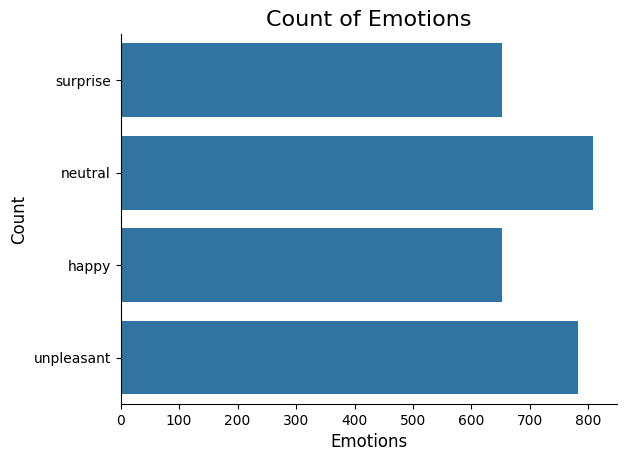

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(aggregated_data.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Data Exploration
In this section, you've plotted waveforms and spectrograms for emotions data, as well as applied different audio transformations like noise addition, time stretching, and pitch shifting to provide an overview of the audio data properties.

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [9]:
def noise(data):
    noise_amp = 0.5*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

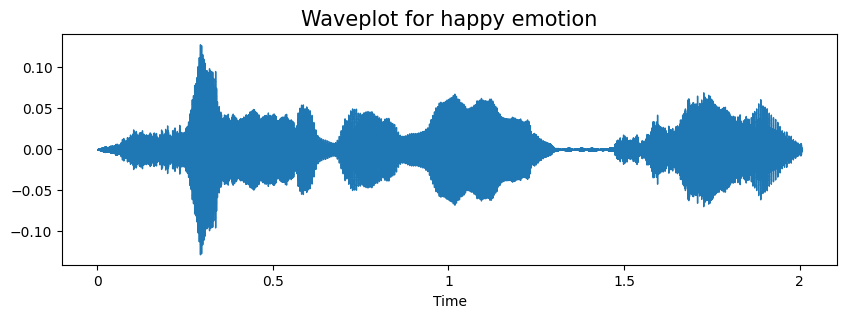

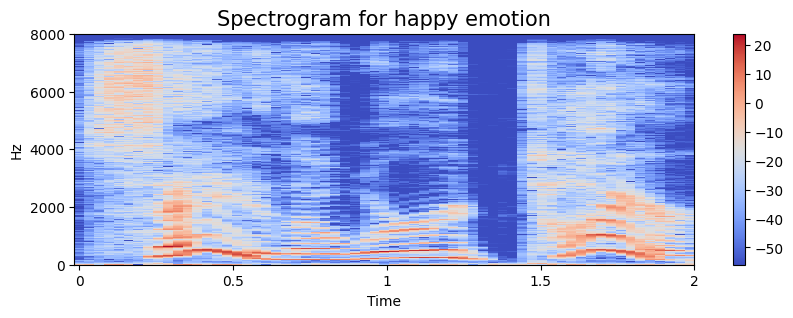

In [10]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Function to create a wave plot
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

# Function to create a spectrogram
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

# Assuming aggregated_data and noise function are defined elsewhere
emotion = 'happy'
path = np.array(aggregated_data.Path[aggregated_data.Emotions == emotion])[1]
data, sample_rate = librosa.load(path)
data = librosa.resample(y=data, orig_sr=sample_rate, target_sr=16000)
noised_data = noise(data)

# Use 16000 as the sample rate everywhere for consistency
create_waveplot(data, 16000, emotion)
create_spectrogram(data, 16000, emotion)
Audio(data=noised_data, rate=16000)

# Key Speech Element Span
# Ravdess_df: 0.8-2.8s -> 2.0s
#    Tess_df: 0.3-1.8s -> 1.5s
#   Savee_df: 0.6-3.3s -> 2.7s

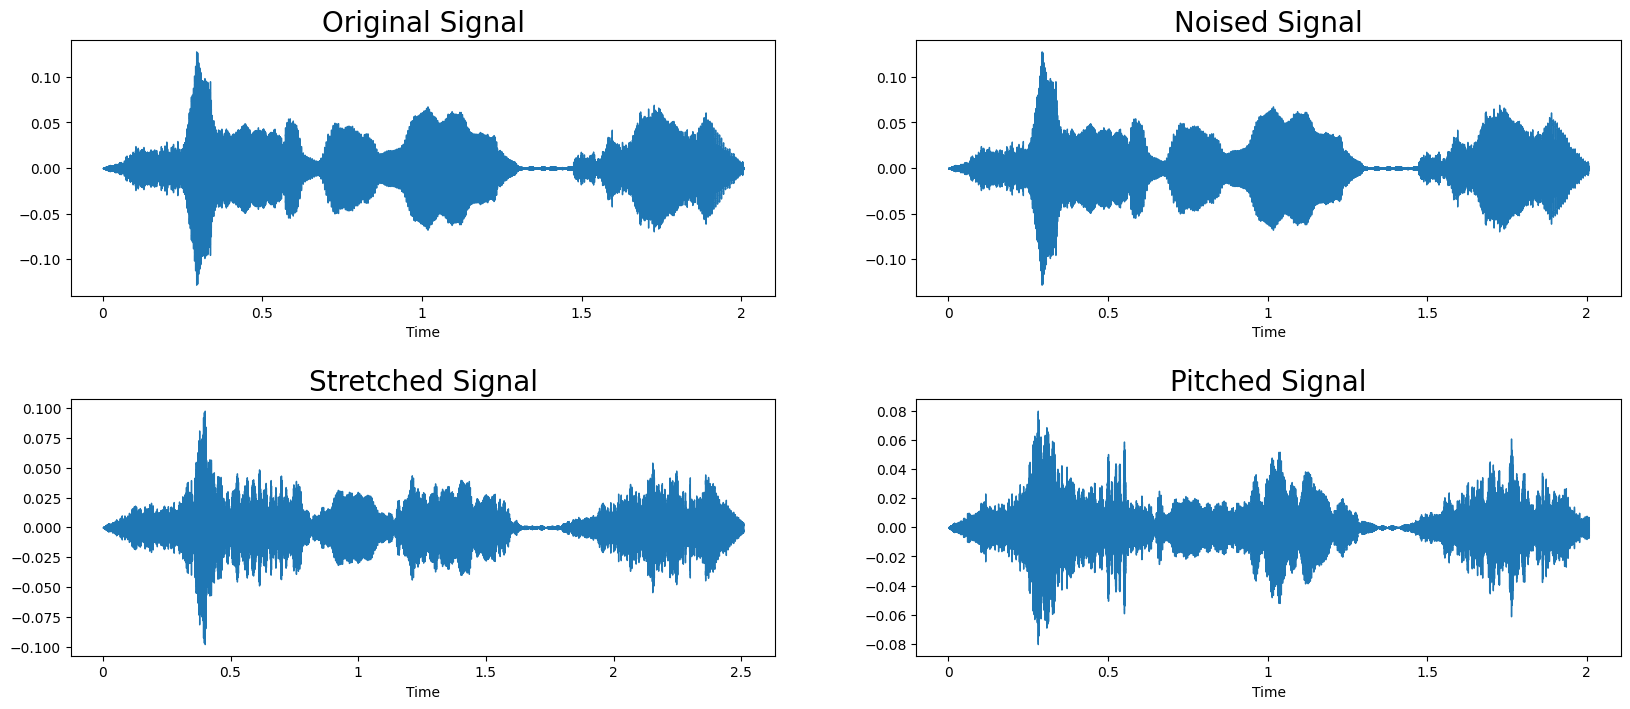

In [11]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Assuming aggregated_data and noise function are defined elsewhere
emotion = 'happy'
path = np.array(aggregated_data.Path[aggregated_data.Emotions == emotion])[1]
data, sample_rate = librosa.load(path)
data = librosa.resample(y=data, orig_sr=sample_rate, target_sr=16000)
sample_rate = 16000  # Update sample_rate to the resampled rate
noised_data = noise(data)

# Function to add noise to the audio data
def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape)
    return data

# Function to stretch the audio data
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to pitch the audio data
def pitch(data, sample_rate, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

# Plotting the signals
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4)

# Plot the original signal
axs[0, 0].set_title('Original Signal', size=20)
librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0, 0])

# Plot the noised signal
axs[0, 1].set_title('Noised Signal', size=20)
noise_data = noise(data)
librosa.display.waveshow(y=noise_data, sr=sample_rate, ax=axs[0, 1])

# Plot the stretched signal
axs[1, 0].set_title('Stretched Signal', size=20)
stretch_data = stretch(data)
librosa.display.waveshow(y=stretch_data, sr=sample_rate, ax=axs[1, 0])

# Plot the pitched signal
axs[1, 1].set_title('Pitched Signal', size=20)
pitch_data = pitch(data, sample_rate)
librosa.display.waveshow(y=pitch_data, sr=sample_rate, ax=axs[1, 1])

plt.show()

## Data Pre-processing
This section preprocesses audio data for speech emotion recognition. It encoded emotion labels, extracts features using MFCC, and augments data with audio transformations. The data is stored in a CSV file and split into training, validation, and testing sets for model training.

In [12]:
labels = {'neutral':0, 'happy':1, 'surprise':2, 'unpleasant': 3}
aggregated_data.replace({'Emotions':labels},inplace=True)
aggregated_data.head()

,Emotions,Path
0,2,/Users/vaibhavtiwari/Downloads/archive/audio_s...
1,0,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
2,0,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
3,0,/Users/vaibhavtiwari/Downloads/archive (1)/TES...
5,0,/Users/vaibhavtiwari/Downloads/archive/audio_s...


In [13]:
import numpy as np
import pandas as pd
import librosa

NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = aggregated_data.shape[0]

data = {
    "labels": [],
    "features": []
}

def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    feature = mfcc.T
    return feature

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

for i in range(SAMPLE_NUM):
    try:
        # Load the audio file
        signal, sample_rate = librosa.load(aggregated_data.iloc[i, 1], sr=SAMPLE_RATE)
        
        # Cropping & Resampling
        start_time = 0.4  # Start time in seconds
        end_time = 1.9  # End time in seconds
        start_frame = int(start_time * sample_rate)
        end_frame = int(end_time * sample_rate)
        signal = signal[start_frame:end_frame]
        signal = librosa.resample(y=signal, orig_sr=sample_rate, target_sr=DOWN_SAMPLE_RATE)
        
        # Add noise
        noisy_signal = noise(signal)
        res1 = extract_features(noisy_signal, DOWN_SAMPLE_RATE)
        data["features"].append(np.array(res1))
        data['labels'].append(aggregated_data.iloc[i, 0])
        
        # Stretch and shift pitch
        stretched_signal = stretch(signal)[:24000]
        pitched_signal = pitch(stretched_signal, DOWN_SAMPLE_RATE)
        res2 = extract_features(pitched_signal, DOWN_SAMPLE_RATE)
        data["features"].append(np.array(res2))
        data['labels'].append(aggregated_data.iloc[i, 0])

    except FileNotFoundError:
        continue
    except Exception as e:
        print(f"Error processing {aggregated_data.iloc[i, 1]}: {e}. Skipping.")
        continue

    if i % 100 == 0:
        print(f'Processing Data: {i}/{SAMPLE_NUM}')

# Verifying lengths of features and labels
features_length = len(data["features"])
labels_length = len(data["labels"])

print(f"Length of features: {features_length}")
print(f"Length of labels: {labels_length}")

if features_length != labels_length:
    print("Error: The lengths of features and labels do not match.")
    # Optional: Handle the mismatch, e.g., trim the longer list to match the shorter one.
    min_length = min(features_length, labels_length)
    data["features"] = data["features"][:min_length]
    data["labels"] = data["labels"][:min_length]

# Create DataFrame
Features = pd.DataFrame()
Features['features'] = data["features"]
Features['labels'] = data["labels"]

# Save to CSV
Features.to_csv('Features.csv', index=False)

# Display the first few rows of the DataFrame
print(Features.head())

Processing Data: 0/2894
Processing Data: 100/2894
Processing Data: 200/2894
Processing Data: 300/2894
Processing Data: 500/2894
Processing Data: 600/2894
Processing Data: 700/2894
Processing Data: 800/2894
Processing Data: 900/2894
Processing Data: 1000/2894
Processing Data: 1100/2894
Processing Data: 1200/2894
Processing Data: 1300/2894
Processing Data: 1400/2894
Processing Data: 1500/2894
Processing Data: 1600/2894
Processing Data: 1700/2894
Processing Data: 1800/2894
Processing Data: 2000/2894
Processing Data: 2100/2894
Processing Data: 2200/2894
Processing Data: 2300/2894
Processing Data: 2400/2894
Processing Data: 2500/2894
Processing Data: 2600/2894
Processing Data: 2700/2894
Processing Data: 2800/2894
Length of features: 5164
Length of labels: 5164
                                            features  labels
0  [[-509.6576196347075, -7.417110366404076, 1.58...       2
1  [[-869.61694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....       2
2  [[-366.83660161660913, 104.76979578630014, 5.3..

In [14]:
X = np.asarray(Features['features'])
y = np.asarray(Features["labels"])

# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f' Testing Data:{X_test.shape} with label {y_test.shape}')

Training Data:(3717, 47, 13) with label (3717,)
Validate Data:(930, 47, 13) with label (930,)
 Testing Data:(517, 47, 13) with label (517,)


## Model Training
This sequential model consists of LSTM layers that capture long-term dependencies in the audio data and the dense layers that transform extracted features to classification.

In [16]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    return model

# Create network
input_shape = (47,13)
model = build_model(input_shape)

# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 47, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,532 (494.27 KB)

 Trainable params: 126,532 (494.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Run the training process
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=EPOCHS)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4099 - loss: 1.2294 - val_accuracy: 0.6957 - val_loss: 0.7328
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7224 - loss: 0.7202 - val_accuracy: 0.7935 - val_loss: 0.5250
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7811 - loss: 0.5496 - val_accuracy: 0.8118 - val_loss: 0.4474
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8043 - loss: 0.4682 - val_accuracy: 0.8086 - val_loss: 0.4999
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8102 - loss: 0.4632 - val_accuracy: 0.7957 - val_loss: 0.4701
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8175 - loss: 0.4189 - val_accuracy: 0.7978 - val_loss: 0.4793
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8201 - loss: 0.4448 - val_accuracy: 0.8290 - val_loss: 0.4152
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8537 - loss: 0.3738 - val_accu

In [30]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Save the TensorFlow model in the current working directory
model_save_path = os.path.join(current_dir, 'Speech-Emotion-Recognition-Model.keras')
try:
    model.save(model_save_path)
    print('Saved the TensorFlow model at:', model_save_path)
except Exception as e:
    print(f"Error saving model: {e}")

Error saving model: 'str' object has no attribute 'save'


## Model Evaluation
We evaluate the speech emotion recognition model by measuring test accuracy, plotting loss and accuracy graphs, printing a classification report, and creating a confusion matrix. These tools help assess the model's performance, identify areas for improvement, and enhance its accuracy and generalization capabilities.

Test Accuracy:  84.91296172142029 %


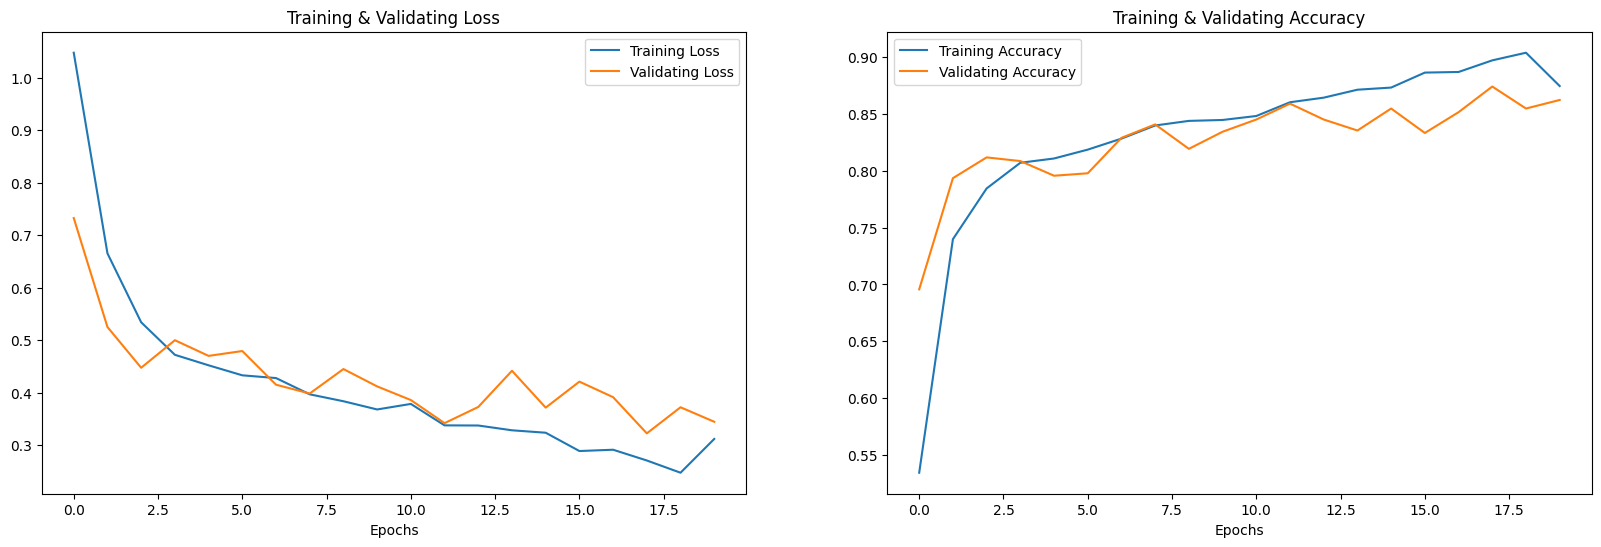

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")


epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, val_acc, label='Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
label_names = list(labels.keys())
print(classification_report(y_test, y_pred, target_names=label_names))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

     neutral       0.77      1.00      0.87       143
       happy       0.85      0.74      0.79       100
    surprise       0.90      0.81      0.85       126
  unpleasant       0.91      0.81      0.86       148

    accuracy                           0.85       517
   macro avg       0.86      0.84      0.84       517
weighted avg       0.86      0.85      0.85       517



The model's performance on speech emotion recognition, as shown by the confusion matrix, achieved an overall accuracy of 0.73. For individual emotions, the f1-scores were: Neutral (0.84), Happy (0.66), Surprise (0.64), and Unpleasant (0.76). The model performs best in recognizing neutral emotions, with a precision of 0.87 and a recall of 0.81. The most challenging emotion to recognize was surprise, with a precision of 0.57 and a recall of 0.74. Overall, the model exhibits satisfactory performance; however, improvements can be made, particularly in the recognition of surprise and happy emotions.

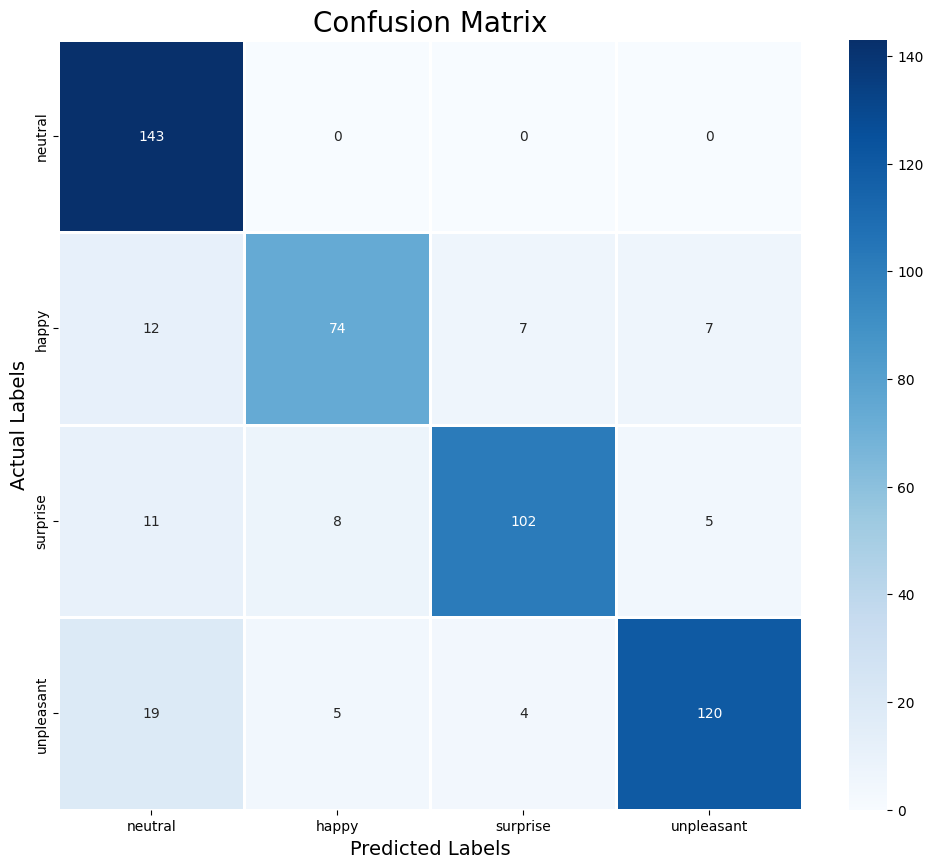

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm)

plt.figure(figsize = (12, 10))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## TinyML Model Conversion & Evaluation
To deploy the speech emotion recognition model on microcontrollers, there are a few steps we have to do to fit in different hardware environments, including post-quantization and model format conversion.

First, we plot the histogram to visualize the model's weights. This step is essential because the conversion can cause accuracy loss due to the reduced precision of the weights. By examining the weight's distribution and range, we can get a sense of the effectiveness of the post-quantization process.

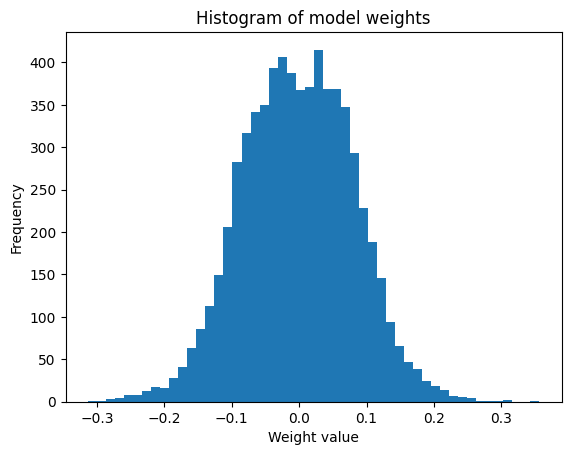

In [22]:
weights = model.get_weights()

# Plot a histogram of the weights
plt.hist(weights[0].flatten(), bins=50)
plt.xlabel('Weight value')
plt.ylabel('Frequency')
plt.title('Histogram of model weights')
plt.show()

Second, we converts the trained model to a TensorFlow Lite format using the TensorFlow Lite framework, which can optimize the model for deployment on mobile devices with limited computational resources. 

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_save_path)
tflite_model = converter.convert()
with tf.io.gfile.GFile("Models/SER.tflite", 'wb') as f:
   f.write(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()
with tf.io.gfile.GFile("Models/SER_quant.tflite", 'wb') as f:
   f.write(quant_tflite_model)

print("Save the Tensorflow 'Lite' model!")

AttributeError: 'str' object has no attribute 'call'

In [ ]:
import tensorflow as tf

# Define the model save paths
tflite_model_path = os.path.join(models_dir, "SER.tflite")
quant_tflite_model_path = os.path.join(models_dir, "SER_quant.tflite")

# Convert the model to TFLite format with Flex ops enabled
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.experimental_enable_resource_variables = True

try:
    # Convert and save the TFLite model
    tflite_model = converter.convert()
    with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print('Saved the TensorFlow Lite model at:', tflite_model_path)

    # Optimize and save the quantized TFLite model
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quant_tflite_model = converter.convert()
    with tf.io.gfile.GFile(quant_tflite_model_path, 'wb') as f:
        f.write(quant_tflite_model)
    print('Saved the quantized TensorFlow Lite model at:', quant_tflite_model_path)

except Exception as e:
    print(f"Error converting model: {e}")

In [ ]:
# List the contents of the Models directory and print their sizes
print("Model Sizes:")
!ls -lh Models | awk '{print $5 "\t" $9}'

We converted the original model to TensorFlow Lite format, which reduced the size to 515K, and we further optimized the size using post-training quantization to convert weights from float32 to int8, resulted in a significant size reduction at 150K. This quantized model is roughly 3.4 times smaller than the non-quantized version and 10 times smaller than the original, demonstrating the effectiveness of model optimization techniques for TinyML applications.

However, the goal of TinyML techniques is to reduce not only the model size but the inference time while maintaining similar accuracy. Therefore, we compare the inference time and accuracy of the original TensorFlow model with the TensorFlow Lite model.

In [ ]:
import numpy as np
import tensorflow as tf

def evaluate_tflite(interpreter, test_data, test_label):
    # Get the input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    num_correct = 0
    num_total = 0

    # Iterate over the testing data.
    for i in range(test_data.shape[0]):
        # Get the input data for this example.
        input_data = np.array([test_data[i]], dtype=np.float32)

        # Set the input tensor.
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference.
        interpreter.invoke()

        # Get the output tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Compute the predicted label.
        predicted_label = np.argmax(output_data)

        # Update the results.
        if predicted_label == test_label[i]:
            num_correct += 1
        num_total += 1

    # Compute the accuracy.
    accuracy = num_correct / num_total
    
    return accuracy

# Load TFLite model.
interpreter = tf.lite.Interpreter(model_path="Models/SER_quant.tflite")
interpreter.allocate_tensors()

# Evaluate TFLite model accuracy.
tflite_test_acc = evaluate_tflite(interpreter, X_test, y_test)
print(f"TF Lite Model Accuracy: {tflite_test_acc * 100:.2f}%")
print(f"Accuracy Difference from Original Model: {(test_acc-tflite_test_acc) * 100:.2f}%")

In [ ]:
input_data = np.random.randn(1, 47, 13).astype(np.float32)

start_time = time.time()
for i in range(100):
    h5_predictions = model.predict(input_data)
h5_inference_time = time.time() - start_time

start_time = time.time()
for i in range(100):
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data)
    interpreter.invoke()
    tflite_predictions = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    interpreter.reset_all_variables()
tflite_inference_time = time.time() - start_time

print("Inference Time Comparison:")
print(f"Original Model: {h5_inference_time}s")
print(f"TF Lite Model: {tflite_inference_time}s")

Lastly, as we have converted the original model into a TensorFlow Lite format, more is needed to deploy the model on a microcontroller. We have to convert the TFLite file into a TFLite "Micro" file which can be uploaded to microcontrollers like Arduino Nano 33 BLE Sense, enabling real-time SER applications with similar accuracy to the original model.

In [ ]:
MODEL_TFLITE = 'Models/SER_quant.tflite'
MODEL_TFLITE_MICRO = 'Models/SER_micro.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}
print("Save the Tensorflow Lite 'Micro' model!")